# Proyek Klasifikasi Gambar: Scene Images Classification
- **Nama:** Muhammad Faishal Ali Dhiaulhaq
- **Email:** faishalald22@gmail.com
- **ID Dicoding:** Muhammad Faishal Ali Dhiaulhaq


## Import Semua Packages/Library yang Digunakan

In [ ]:
import pandas as pd
import os
import numpy as np
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflowjs as tfjs


from sklearn.metrics import confusion_matrix
from skimage.exposure import adjust_gamma
from skimage.transform import AffineTransform, warp
import cv2
from tqdm import tqdm
from scipy.ndimage import rotate

## Data Loading

In [3]:
# Path Dataset
DATA_PATH = 'data/'

# Path Dataset Nama File 
dataName = os.path.join(DATA_PATH, 'train - train.csv')

dfName = pd.read_csv(dataName)
dfName.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17093 entries, 0 to 17092
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  17093 non-null  object
 1   label       17093 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 267.2+ KB


### Pemetaan Data Gambar ke Direktori Berdasarkan Kelas

In [4]:
rawImageDir = os.path.join(DATA_PATH, 'scene_images')

files = set(os.listdir(rawImageDir))
# Membuat direktori tujuan
destPath = os.path.join(DATA_PATH, 'fix-data')
os.makedirs(destPath, exist_ok=True)
# Membuat direktori per kategori
os.makedirs(os.path.join(destPath, 'building'), exist_ok=True)
os.makedirs(os.path.join(destPath, 'forest'), exist_ok=True)
# os.makedirs(os.path.join(destPath, 'glacier'), exist_ok=True)
os.makedirs(os.path.join(destPath, 'mountain'), exist_ok=True)
os.makedirs(os.path.join(destPath, 'sea'), exist_ok=True)
os.makedirs(os.path.join(destPath, 'street'), exist_ok=True)


for index, row in dfName.iterrows():
    image = row['image_name']
    label = row['label']
    
    if image in files:
        print(f'Data ke-{index} - {image} - {label}')
        sourcePath = os.path.join(rawImageDir, image)
        try:
            if os.path.exists(sourcePath):
                if label == 0:
                    shutil.copy(sourcePath, os.path.join(destPath, 'building', image))
                elif label == 1:
                    shutil.copy(sourcePath, os.path.join(destPath, 'forest', image))
                # elif label == 2:
                #     shutil.copy(sourcePath, os.path.join(destPath, 'glacier', image))
                elif label == 3:
                    shutil.copy(sourcePath, os.path.join(destPath, 'mountain', image))
                elif label == 4:
                    shutil.copy(sourcePath, os.path.join(destPath, 'sea', image))
                elif label == 5:
                    shutil.copy(sourcePath, os.path.join(destPath, 'street', image))
        except Exception as e:
            print(e)
            continue


Data ke-0 - 0.jpg - 0
Data ke-1 - 1.jpg - 4
Data ke-2 - 2.jpg - 5
Data ke-3 - 4.jpg - 0
Data ke-4 - 7.jpg - 4
Data ke-5 - 8.jpg - 1
Data ke-6 - 9.jpg - 5
Data ke-7 - 10.jpg - 2
Data ke-8 - 12.jpg - 5
Data ke-9 - 13.jpg - 2
Data ke-10 - 15.jpg - 2
Data ke-11 - 16.jpg - 3
Data ke-12 - 17.jpg - 3
Data ke-13 - 18.jpg - 2
Data ke-14 - 19.jpg - 5
Data ke-15 - 20.jpg - 4
Data ke-16 - 21.jpg - 4
Data ke-17 - 23.jpg - 1
Data ke-18 - 24.jpg - 2
Data ke-19 - 26.jpg - 5
Data ke-20 - 27.jpg - 4
Data ke-21 - 29.jpg - 5
Data ke-22 - 31.jpg - 5
Data ke-23 - 32.jpg - 3
Data ke-24 - 33.jpg - 5
Data ke-25 - 34.jpg - 3
Data ke-26 - 35.jpg - 5
Data ke-27 - 36.jpg - 5
Data ke-28 - 37.jpg - 5
Data ke-29 - 39.jpg - 5
Data ke-30 - 40.jpg - 2
Data ke-31 - 41.jpg - 1
Data ke-32 - 42.jpg - 3
Data ke-33 - 43.jpg - 2
Data ke-34 - 44.jpg - 3
Data ke-35 - 45.jpg - 5
Data ke-36 - 46.jpg - 1
Data ke-37 - 47.jpg - 0
Data ke-38 - 48.jpg - 1
Data ke-39 - 49.jpg - 1
Data ke-40 - 50.jpg - 5
Data ke-41 - 53.jpg - 0
Data ke-4

Penghilangan kelas **Glacier** disebabkan data kurang baik, yang menghambat penambahan akurasi.

### Menampilkan Contoh Dari Setiap Kategori

In [54]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0
 
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images
 
        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")
 
    print(f"\nTotal: {total_images}")
    print(f"Unique sizes: {unique_sizes}")

print_images_resolution(destPath)

building: 23652
- (277, 277)
- (263, 263)
- (272, 272)
- (309, 309)
- (314, 314)
- (282, 282)
- (259, 259)
- (300, 300)
- (310, 310)
- (296, 296)
- (305, 305)
- (232, 232)
- (287, 287)
- (250, 250)
- (315, 315)
- (306, 306)
- (246, 246)
- (228, 228)
- (301, 301)
- (269, 269)
- (150, 150)
- (292, 292)
- (256, 256)
- (311, 311)
- (316, 316)
- (274, 274)
- (224, 224)
- (289, 289)
- (307, 307)
- (298, 298)
- (266, 266)
- (243, 243)
- (303, 303)
- (239, 239)
- (294, 294)
- (285, 285)
- (280, 280)
- (312, 312)
- (253, 253)
- (235, 235)
- (317, 317)
- (150, 124)
- (313, 313)
---------------
forest: 24705
- (150, 136)
- (277, 277)
- (263, 263)
- (272, 272)
- (309, 309)
- (150, 133)
- (314, 314)
- (282, 282)
- (259, 259)
- (150, 108)
- (300, 300)
- (310, 310)
- (296, 296)
- (305, 305)
- (232, 232)
- (287, 287)
- (250, 250)
- (315, 315)
- (306, 306)
- (150, 135)
- (150, 141)
- (246, 246)
- (228, 228)
- (301, 301)
- (269, 269)
- (150, 150)
- (292, 292)
- (256, 256)
- (311, 311)
- (316, 316)
- (27

Category: building, Image: 5358.jpg, Resolution: (150, 124)
Category: building, Image: 1415.jpg, Resolution: (150, 150)
Category: building, Image: 18324.jpg, Resolution: (150, 150)
Category: building, Image: 22735.jpg, Resolution: (150, 150)
Category: building, Image: 5638.jpg, Resolution: (150, 150)
Category: forest, Image: 12108.jpg, Resolution: (150, 108)
Category: forest, Image: 14152.jpg, Resolution: (150, 150)
Category: forest, Image: 18636.jpg, Resolution: (150, 150)
Category: forest, Image: 23299.jpg, Resolution: (150, 150)
Category: forest, Image: 5754.jpg, Resolution: (150, 150)
Category: mountain, Image: 22765.jpg, Resolution: (150, 81)
Category: mountain, Image: 14323.jpg, Resolution: (150, 150)
Category: mountain, Image: 18737.jpg, Resolution: (150, 150)
Category: mountain, Image: 2311.jpg, Resolution: (150, 150)
Category: mountain, Image: 5626.jpg, Resolution: (150, 150)
Category: sea, Image: 19551.jpg, Resolution: (150, 113)
Category: sea, Image: 14626.jpg, Resolution: (

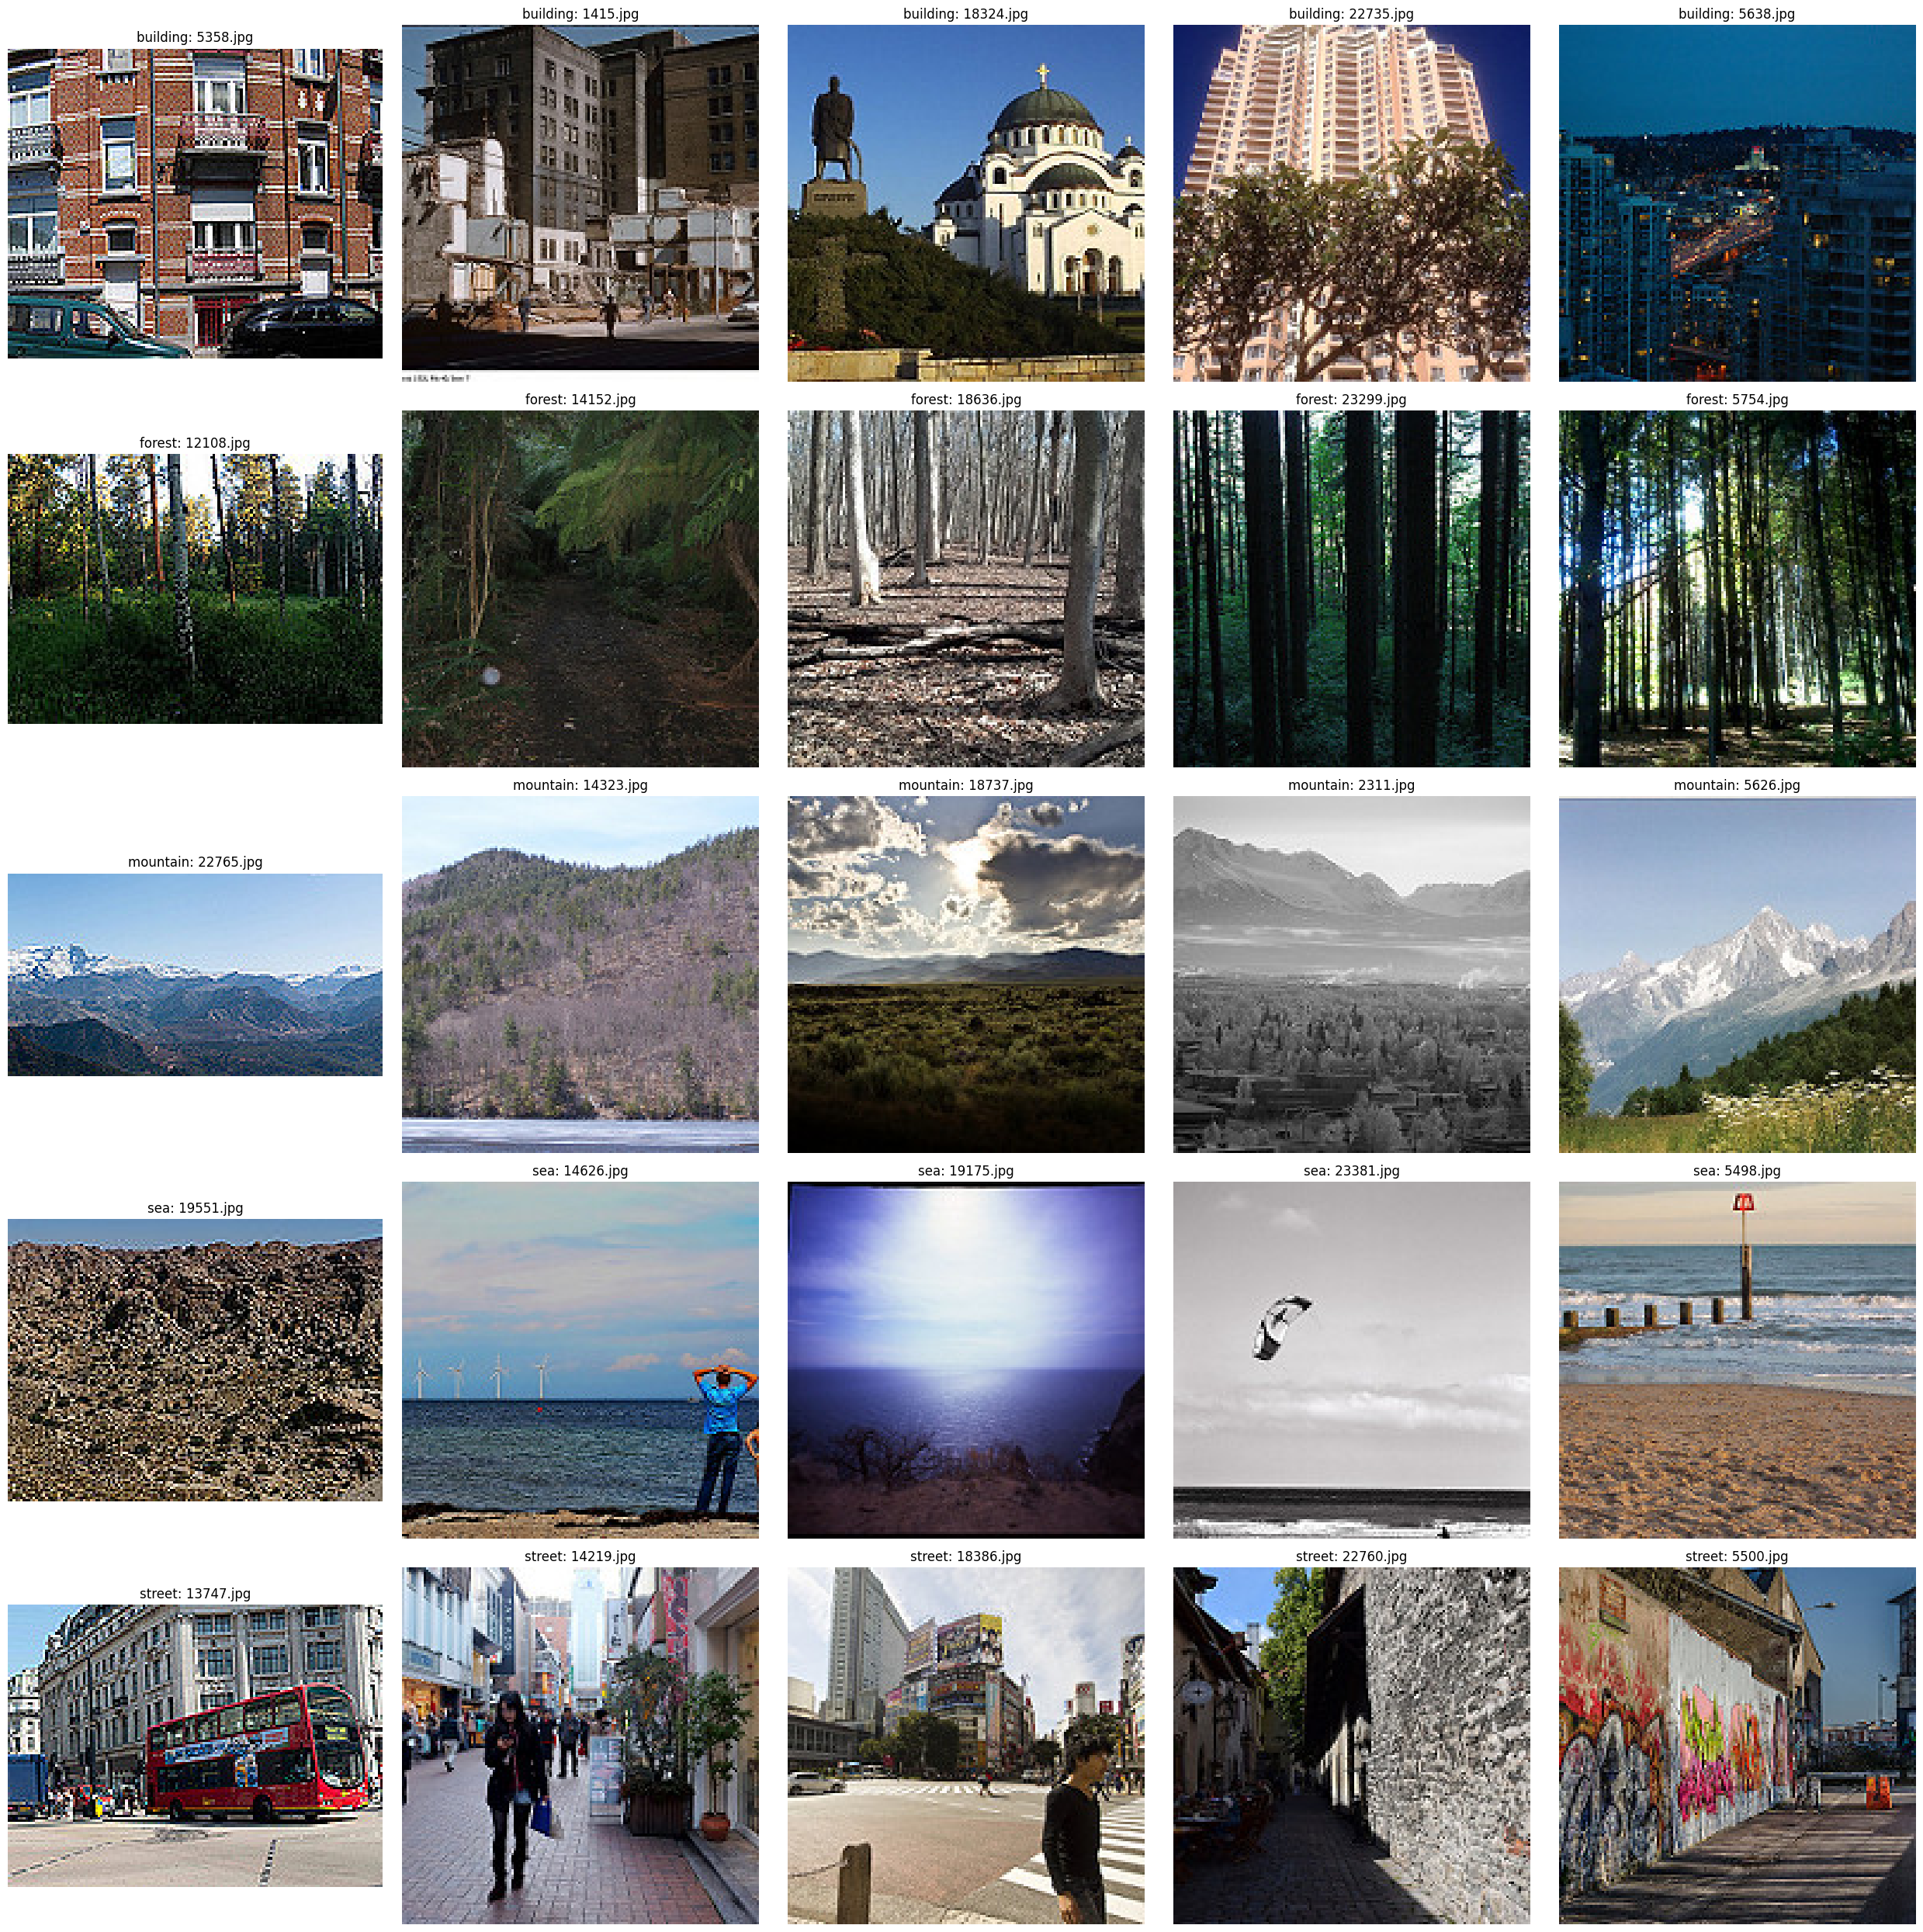

In [5]:
def plot_image_samples(base_path, num_samples=5, resolution_variation=True):
    """
    Menampilkan contoh gambar dari setiap kategori dengan opsi memilih resolusi beragam.

    Args:
        base_path (str): Path ke folder utama dataset.
        num_samples (int): Jumlah gambar per kategori yang ingin ditampilkan.
        resolution_variation (bool): Jika True, pilih gambar dengan resolusi beragam jika memungkinkan.
    """
    categories = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

    # Tentukan ukuran plot berdasarkan jumlah kategori
    fig, axes = plt.subplots(len(categories), num_samples, figsize=(5 * num_samples, 5 * len(categories)))
    if len(categories) == 1:
        axes = [axes]  # Jika hanya satu kategori

    for i, category in enumerate(categories):
        category_path = os.path.join(base_path, category)
        images = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

        if resolution_variation:
            # Kumpulkan resolusi gambar
            image_resolutions = []
            for img_name in images:
                img_path = os.path.join(category_path, img_name)
                img = Image.open(img_path)
                image_resolutions.append((img_name, img.size))

            # Sortir gambar berdasarkan resolusi
            image_resolutions.sort(key=lambda x: x[1][0] * x[1][1])

            # Ambil gambar dengan resolusi beragam
            interval = max(3, len(image_resolutions) // num_samples)
            sampled_images = [image_resolutions[i][0] for i in range(0, len(image_resolutions), interval)][:num_samples]
        else:
            sampled_images = random.sample(images, min(len(images), num_samples))

        for j, img_name in enumerate(sampled_images):
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path)

            # Print resolusi gambar
            print(f"Category: {category}, Image: {img_name}, Resolution: {img.size}")

            # Plot gambar
            ax = axes[i][j] if num_samples > 1 else axes[i]
            ax.imshow(img)
            ax.set_title(f"{category}: {img_name}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_image_samples(destPath, num_samples=5, resolution_variation=True)

## Data Preparation

### Plot Presentase Data

In [10]:
def plot_train_test_distribution(train_path):
    """
    Plot distribusi data dalam direktori train dan test.

    Args:
        train_path (str): Path ke direktori train.
        test_path (str): Path ke direktori test.
    """
    train_categories = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]
    train_counts = [len(os.listdir(os.path.join(train_path, cat))) for cat in train_categories]

    plt.figure(figsize=(8, 8))
    plt.pie(train_counts, labels=train_categories, autopct=lambda p: f'{int(round(p * sum(train_counts) / 100))}', startangle=140)
    plt.title("Distribusi Data dalam Train Set (Count)")
    plt.show()

## Data Augmentation

In [7]:
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    sudut = random.randint(0, 180)
    return rotate(img, sudut)

def clockwise_rotation(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    sudut = random.randint(0, 180)
    return rotate(img, -sudut)

def flip_up_down(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    return np.flipud(img)

def add_brightness(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = adjust_gamma(img, gamma=0.5, gain=1)
    return img

def blur_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    return cv2.GaussianBlur(img, (9, 9), 0)

def sheared(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return (shear_image * 255).astype(np.uint8)

def warp_shift(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    transform = AffineTransform(translation=(0, 40))
    warp_image = warp(img, transform, mode="wrap")
    return (warp_image * 255).astype(np.uint8)

def color_jitter(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0
    img[:, :, 0] = np.clip(img[:, :, 0] * random.uniform(0.8, 1.2), 0, 1)
    img[:, :, 1] = np.clip(img[:, :, 1] * random.uniform(0.8, 1.2), 0, 1)
    img[:, :, 2] = np.clip(img[:, :, 2] * random.uniform(0.8, 1.2), 0, 1)
    return (img * 255).astype(np.uint8)

In [8]:
def apply_augmentation(train_path):
    augmentations = [anticlockwise_rotation, clockwise_rotation, flip_up_down, add_brightness, blur_image, sheared, warp_shift, color_jitter]
    categories = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

    for category in categories:
        category_path = os.path.join(train_path, category)
        images = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

        for idx, img_name in enumerate(tqdm(images, desc=f"Processing category: {category}")):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)

            for aug_func in augmentations:
                augmented_img = aug_func(img)
                augmented_img_name = f"aug_{aug_func.__name__}_{img_name}"
                augmented_img_path = os.path.join(category_path, augmented_img_name)
                cv2.imwrite(augmented_img_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))

In [9]:
apply_augmentation(destPath)

Processing category: street: 100%|██████████| 2884/2884 [01:38<00:00, 29.22it/s]


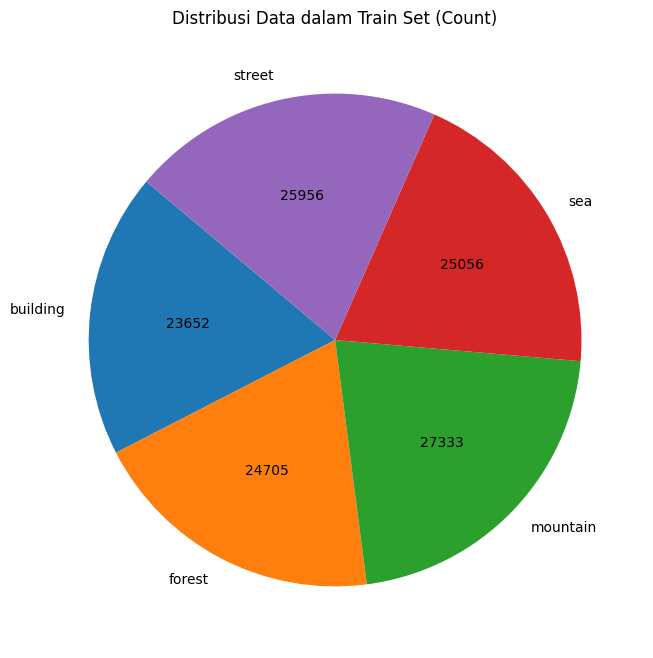

In [11]:
# Plot Ulang Banyak Data
plot_train_test_distribution(destPath)

## Modelling

In [12]:
img_height, img_width = 315, 315 # Dimensi gambar input
batch_size = 32  # Ukuran batch
epochs = 15  # Jumlah epoch
num_classes = 6  # Jumlah kategori

In [14]:
# Fungsi Preprocessing dengan Padding
def preprocess_with_padding(image, target_size=(140, 140)):
    """
    Fungsi untuk menambahkan padding pada gambar kecil dan mengubah ukurannya.
    """
    img_height, img_width = image.shape[0], image.shape[1]
    
    # Menghitung perbedaan antara ukuran gambar dan target_size
    delta_w = target_size[1] - img_width
    delta_h = target_size[0] - img_height

    # Padding
    top, bottom = delta_h // 2, delta_h - delta_h // 2
    left, right = delta_w // 2, delta_w - delta_w // 2

    # Memberikan padding pada gambar
    padded_image = np.pad(image, ((top, bottom), (left, right), (0, 0)), mode='constant', constant_values=0)

    # Resize gambar dengan padding yang sudah diterapkan
    img = array_to_img(padded_image)
    img = img.resize(target_size)
    
    return img_to_array(img)  # Mengembalikan gambar yang sudah diproses

# Data Generator dengan Preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalisasi
    rotation_range=10,    # Menurunkan range rotasi agar tidak terlalu banyak distorsi
    width_shift_range=0.1,  # Menyesuaikan shifting dengan sedikit pergeseran
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,  # Zoom lebih kecil
    horizontal_flip=True,
    validation_split=0.2, 
    preprocessing_function=lambda x: preprocess_with_padding(x, (img_height, img_width))
)

# Data Train dan Validation
train_data = datagen.flow_from_directory(
    destPath,
    target_size=(img_height, img_width),  # Resolusi target
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Menyebutkan subset training
)

validation_data = datagen.flow_from_directory(
    destPath,
    target_size=(img_height, img_width),  # Resolusi target
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Menyebutkan subset validation
)

Found 101363 images belonging to 5 classes.
Found 25339 images belonging to 5 classes.


In [15]:
# Callback untuk menghentikan training jika akurasi training dan testing minimal 97%
class AccuracyStopCallback(Callback):
    def __init__(self, train_accuracy_threshold=0.97, val_accuracy_threshold=0.97):
        super().__init__()
        self.train_accuracy_threshold = train_accuracy_threshold
        self.val_accuracy_threshold = val_accuracy_threshold

    def on_epoch_end(self, epoch, logs=None):
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        # Cek apakah akurasi training dan testing sudah mencapai threshold
        if train_accuracy >= self.train_accuracy_threshold and val_accuracy >= self.val_accuracy_threshold:
            print(f'\nAkurasi training dan testing sudah mencapai {self.train_accuracy_threshold*100}% atau lebih, menghentikan training.')
            self.model.stop_training = True

# Tambahkan callback kustom untuk berhenti ketika akurasi mencapai 85%
accuracy_stop_callback = AccuracyStopCallback(train_accuracy_threshold=0.97, val_accuracy_threshold=0.97)

In [16]:
# Learning Rate Scheduler
def lr_scheduler(epoch):
    if epoch < 10:
        return 0.0001
    elif epoch < 20:
        return 0.00001
    else:
        return 0.000001

lr_callback = LearningRateScheduler(lr_scheduler)

In [17]:
optimizer = tf.keras.optimizers.Adam(decay=1e-6)

In [20]:
# Memuat Model Pretrained InceptionV3 sebagai base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Membuka pelatihan untuk 20 lapisan terakhir
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

model = models.Sequential([
    base_model, # Base model

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  
    layers.MaxPooling2D(pool_size=(2, 2), padding='valid'),        
    layers.BatchNormalization(), 
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  
    layers.MaxPooling2D(pool_size=(2, 2), padding='valid'),        
    layers.BatchNormalization(),  
    layers.Dropout(0.4),

    # Menambahkan lapisan Flatten untuk mengubah output menjadi satu dimensi
    layers.Flatten(),

    # Menambahkan lapisan Dense untuk klasifikasi
    layers.Dense(512, activation='relu'),
    layers.Dense(5, activation='softmax')  # Output layer dengan 5 neuron (jumlah kategori)
])

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=validation_data,
    callbacks=[accuracy_stop_callback, lr_callback]
)


Epoch 1/15
3168/3168 [==============================] - 2816s 888ms/step - loss: 0.2170 - accuracy: 0.9218 - val_loss: 0.0832 - val_accuracy: 0.9707 - lr: 1.0000e-04
Epoch 2/15
3168/3168 [==============================] - 2308s 728ms/step - loss: 0.1428 - accuracy: 0.9483 - val_loss: 0.0676 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 3/15
3168/3168 [==============================] - 2666s 841ms/step - loss: 0.1210 - accuracy: 0.9568 - val_loss: 0.0596 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 4/15
3168/3168 [==============================] - 2534s 800ms/step - loss: 0.1051 - accuracy: 0.9617 - val_loss: 0.0556 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 5/15
3168/3168 [==============================] - 2302s 727ms/step - loss: 0.0937 - accuracy: 0.9658 - val_loss: 0.0452 - val_accuracy: 0.9838 - lr: 1.0000e-04
Epoch 6/15
3168/3168 [==============================] - 1648s 520ms/step - loss: 0.0830 - accuracy: 0.9700 - val_loss: 0.0410 - val_accuracy: 0.9853 - lr: 1.0000e-04
Epoc

## Evaluation & Visualization

In [21]:
# Mendapatkan ground-truth labels dari validation_data
y_val = validation_data.classes

# Mendapatkan nama kelas
class_names = list(validation_data.class_indices.keys())
class_names

['building', 'forest', 'mountain', 'sea', 'street']

### Confussion Matrix

792/792 [==============================] - 317s 399ms/step


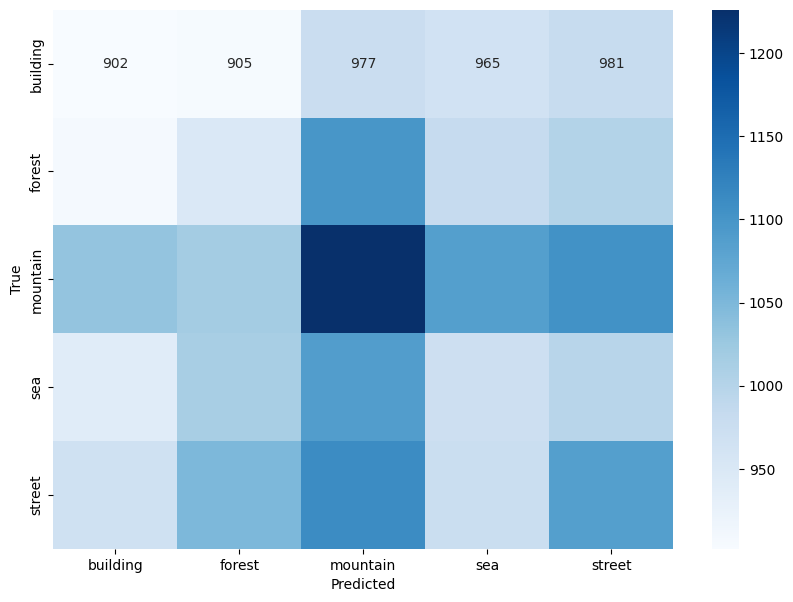

In [22]:
y_pred = model.predict(validation_data)
cm = confusion_matrix(y_val, y_pred.argmax(axis=1))  # y_pred.argmax() untuk multi-class

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Loss Curve

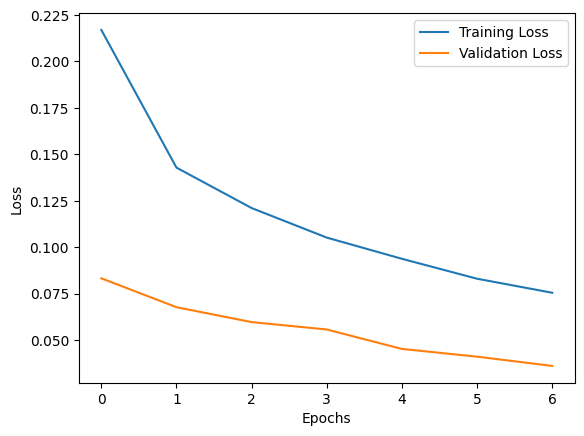

In [32]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy Curve

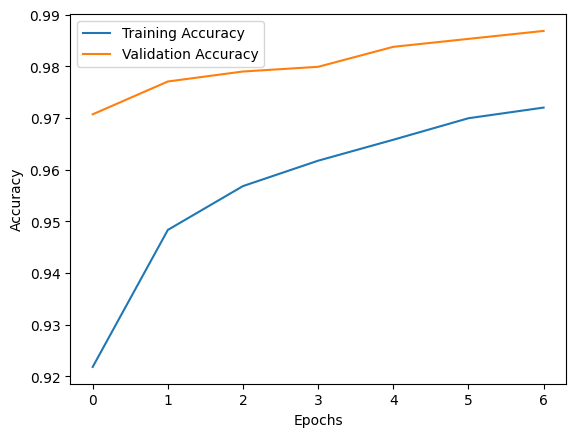

In [33]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Model Converting

In [27]:
os.makedirs('best_model/', exist_ok=True)

### 1. Format Keras

In [28]:
keras_model_path = "best_model/keras/model.keras"
model.save(keras_model_path)
print(f"Model telah disimpan dalam format Keras (.keras) di {keras_model_path}")

Model telah disimpan dalam format Keras (.keras) di best_model/keras/model.keras


### 2. Format TF Lite

In [34]:
os.makedirs('best_model/tflite/', exist_ok=True)

In [35]:
tflite_model_path = "best_model/tflite/model.tflite"

# Konversi model Keras ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TensorFlow Lite (.tflite)
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)
print(f"Model telah disimpan dalam format TensorFlow Lite (.tflite) di {tflite_model_path}")

INFO:tensorflow:Assets written to: C:\Users\legion\AppData\Local\Temp\tmpl0kngpwe\assets


INFO:tensorflow:Assets written to: C:\Users\legion\AppData\Local\Temp\tmpl0kngpwe\assets


Model telah disimpan dalam format TensorFlow Lite (.tflite) di best_model/tflite/model.tflite


### 3. Format Tensorflow.js

In [53]:
tfjs_target_dir = "best_model/tfjs_model"
os.makedirs(tfjs_target_dir, exist_ok=True)

# Konversi dan simpan model dalam format TensorFlow.js
tfjs.converters.save_keras_model(model, tfjs_target_dir)
print(f"Model telah disimpan dalam format TensorFlow.js di {tfjs_target_dir}")

Model telah disimpan dalam format TensorFlow.js di best_model/tfjs_model


### 4. Format SavedModel

In [36]:
saved_model_dir = "best_model/saved_model"  
os.makedirs(saved_model_dir, exist_ok=True)

# Simpan model dalam format SavedModel
model.save(saved_model_dir)
print(f"Model telah disimpan dalam format SavedModel di {saved_model_dir}")

INFO:tensorflow:Assets written to: best_model/saved_model\assets


INFO:tensorflow:Assets written to: best_model/saved_model\assets


Model telah disimpan dalam format SavedModel di best_model/saved_model


### Membuat Label.txt

In [37]:
# Menulis label ke dalam file label.txt
with open('label.txt', 'w') as file:
    for label in class_names:
        file.write(f"{label}\n")

print("File label.txt telah dibuat dengan label kelas model.")

File label.txt telah dibuat dengan label kelas model.


## Inference (Dengan TFLite)

In [38]:
interpreter = tf.lite.Interpreter(model_path="best_model/tflite/model.tflite")
interpreter.allocate_tensors()

# Mendapatkan detail input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [44]:
def inference(imagePath):
    # Memuat gambar dan mengonversinya ke format RGB
    image = Image.open(imagePath).convert("RGB")  # Mengonversi ke RGB (3 channel)

    image = image.resize((315, 315))

    sample_image = np.array(image) / 255.0  # Normalisasi gambar

    sample_image = sample_image.astype(np.float32)

    input_data = np.expand_dims(sample_image, axis=0)  # Menambahkan dimensi batch
    interpreter.set_tensor(input_details[0]['index'], input_data)
    # Menjalankan model
    interpreter.invoke()

    # Mendapatkan output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_index = np.argmax(output_data)  # Menentukan index prediksi tertinggi
    predicted_label = class_names[predicted_index]  # Mengambil label sesuai dengan index

    print(f"Prediksi Model    : {predicted_label}")

    plt.imshow(sample_image.squeeze(), cmap="gray")
    plt.title(f"Prediksi: {predicted_label}")
    plt.axis('off')
    plt.show()

Inference Kelas **Forest**

Prediksi Model    : forest


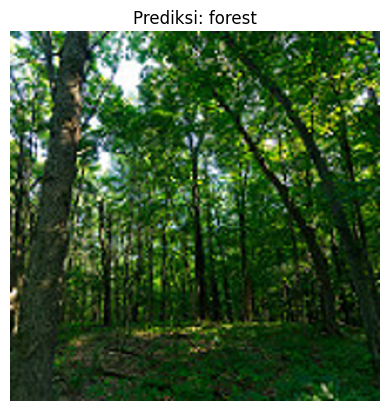

In [45]:
imgPath = 'data/inference/1018.jpg'
inference(imgPath)

Inference Kelas **Sea**

Prediksi Model    : sea


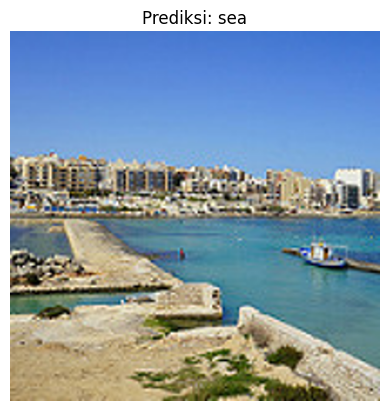

In [47]:
imgPath = 'data/inference/10187.jpg'
inference(imgPath)

Inference Kelas **Mountain**

Prediksi Model    : mountain


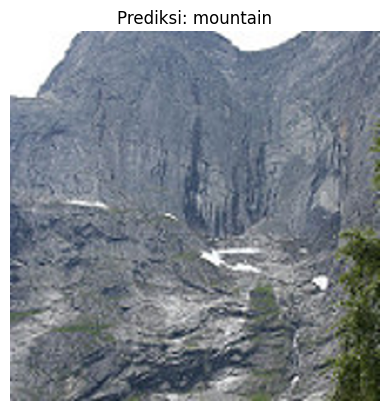

In [48]:
imgPath = 'data/inference/10190.jpg'
inference(imgPath)

Inference Kelas **Street**

Prediksi Model    : street


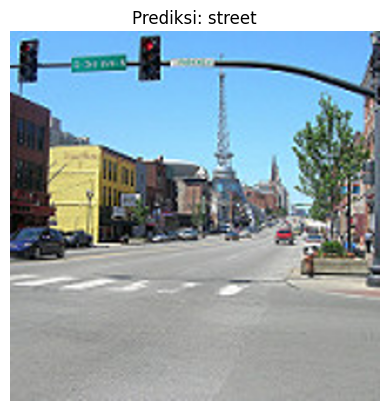

In [49]:
imgPath = 'data/inference/10199.jpg'
inference(imgPath)

Inference Kelas **Building**

Prediksi Model    : building


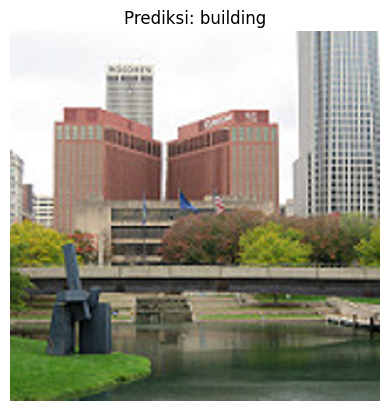

In [51]:
imgPath = 'data/inference/1009.jpg'
inference(imgPath)